# Data Collection

## List the data you need and how much you need.

We will use Financial data with these features:
- **Step**: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- **Type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- **Amount**: amount of the transaction in local currency.
- **Sender Balance**: initial balance before the transaction.
- **Receiver Balance**: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- **isFraud**: is this transaction were considered as fraud or no.

We need approximatelly a IID balanced data with 100_000 transactions.

## Find and document where you can get that data

Data is available at <a href="https://www.kaggle.com/datasets/ealaxi/paysim1">kaggle</a> with additional features but not neseccary for fraud detection.

## Check how much space it will take

With all the 24 million transactions, It takes ~500 mb.

## Check legal obligations, and get authorization if necessary.

Its an open-source data.

## Get Data

Download data from kaggle should be located at **../data/PS_20174392719_1491204439457_log**

### NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.

## Convert the data to a better format

In [1]:
import numpy as np
import pandas as pd

In [76]:
# Load CSV Data
data_path = r"../data/PS_20174392719_1491204439457_log.csv"
data = pd.read_csv(data_path,engine="pyarrow")

In [77]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [78]:
# Check Balance of Data
np.unique(data.isFraud,return_counts=True)

(array([0, 1], dtype=int64), array([6354407,    8213], dtype=int64))

What a bad imbalance betweem the two targets.

In [79]:
# Select Only Columns necessary for Fraud Detection
cols_to_select = ["step","type","amount","oldbalanceOrg","oldbalanceDest","isFraud"]
data = data[cols_to_select]

In [80]:
# Rename Columns
data.columns = ["MonthlyHour","Type","Amount","SenderBalance","ReceiverBalance","isFraud"]

In [81]:
# Check Each Type and number of records
import numpy as np
np.unique(data.Type,return_counts=True)

(array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
       dtype=object),
 array([1399284, 2237500,   41432, 2151495,  532909], dtype=int64))

In [98]:
data.Type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [124]:
# Select records with Balanced Transaction Type and Balanced Target
num_records_per_type = 10_000
sampled_data = []

for txn_type in data.Type.unique():
    # Filter data for the current transaction type
    good_data = data[(data.Type == txn_type) & (data.isFraud == 0)]
    bad_data = data[(data.Type == txn_type) & (data.isFraud == 1)]
    
    sampled_good = good_data.sample(n=min(len(good_data), num_records_per_type), random_state=42)
    
    # Oversample fraud data if necessary
    if len(bad_data) > 0:
        if len(bad_data) < num_records_per_type:
            sampled_bad = bad_data.sample(n=num_records_per_type, replace=True, random_state=42)
        else:
            sampled_bad = bad_data.sample(n=num_records_per_type, random_state=42)
    else:
        sampled_bad = pd.DataFrame()  # Empty DataFrame if no fraud records exist
    
    # Combine good and bad samples for the current transaction type
    current_sampled_data = pd.concat([sampled_good, sampled_bad], axis=0)
    
    # Append the current transaction type's sampled data to the list
    sampled_data.append(current_sampled_data)

# Combine all sampled data into a single DataFrame
sampled_data = pd.concat(sampled_data, axis=0)

# Reset the index after combining all the data
sampled_data.reset_index(drop=True, inplace=True)

print(f"Sampled data shape: {sampled_data.shape}")

Sampled data shape: (70000, 6)


In [122]:
sampled_data

,index,MonthlyHour,Type,Amount,SenderBalance,ReceiverBalance,isFraud
0,4272564,307,PAYMENT,18505.16,9141.0,0.00,0
1,2697361,211,PAYMENT,289.33,1697.0,0.00,0
2,982284,44,PAYMENT,11260.18,104701.0,0.00,0
3,2190099,185,PAYMENT,6479.49,0.0,0.00,0
4,5536099,381,PAYMENT,3397.28,41722.0,0.00,0
...,...,...,...,...,...,...,...
3662206,6362253,718,CASH_IN,188888.89,51838.0,0.00,0
3662207,6362271,718,CASH_IN,27919.60,2413.0,512791.59,0
3662208,6362279,718,CASH_IN,78988.38,204464.0,108724.19,0
3662209,6362298,718,CASH_IN,18000.26,63409.0,28088.61,0


<Axes: xlabel='count', ylabel='Type'>

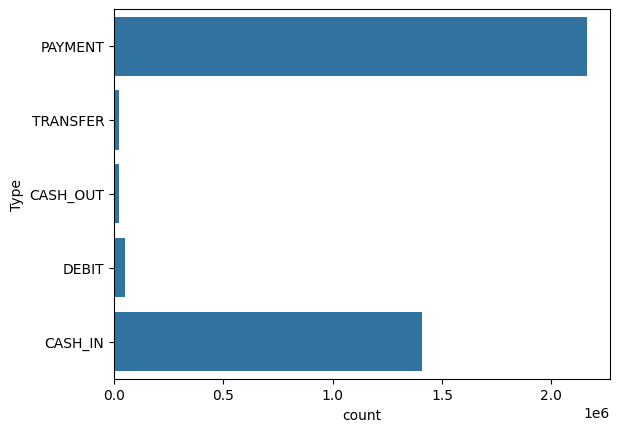

In [123]:
sns.countplot(sampled_data.Type)

In [120]:
np.unique(sampled_data.isFraud.values,return_counts=True)

(array([0], dtype=int64), array([3622211], dtype=int64))

## Ensure sensitive information is deleted or protected

Its a Synthetic data.

## Check the size and type of data

Its a **time series** data cause each transaction is associated with a timestamp.

Contains **24 million** financial records.

## Sample a test set

In [19]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(sampled_data,stratify=sampled_data.isFraud,test_size=0.1,random_state=42)

In [20]:
train_data.to_csv("../data/train_data.csv",index=False)
test_data.to_csv("../data/test_data.csv",index=False)